# Generating Summary Fragments

Using the long wikipedia plot descriptions, associate several sentences randomly chosen from summaries of different segments of the plot.

## Import & setup
Load data, import necessary packages, and drop bad data.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd

corpus_location = "/content/gdrive/MyDrive/wiki_movies_no_cites.csv"

cleaned_corpus = pd.read_csv(corpus_location)

In [ ]:
cleaned_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        34886 non-null  int64 
 1   Release Year      34886 non-null  int64 
 2   Title             34886 non-null  object
 3   Origin/Ethnicity  34886 non-null  object
 4   Director          34886 non-null  object
 5   Cast              33464 non-null  object
 6   Genre             34884 non-null  object
 7   Wiki Page         34886 non-null  object
 8   Plot              34886 non-null  object
dtypes: int64(2), object(7)
memory usage: 2.4+ MB


In [ ]:
compute_length = lambda x: len(x.split())

cleaned_corpus['plot_length'] = cleaned_corpus.apply(lambda df: compute_length(df['Plot']), 
                                                     axis=1)

In [ ]:
# Manual investigation shows that very short plots (< 50 chars) comes from badly parsed wiki pages
# These lack any detail AT ALL about the movie
truncated_corpus = cleaned_corpus.drop(cleaned_corpus[cleaned_corpus.plot_length < 50].index)

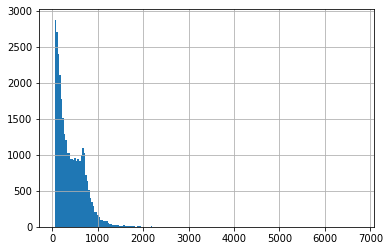

In [ ]:
truncated_corpus['plot_length'].hist(bins=200)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 9.4 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 64.6 MB/s 
     |████████████████████████████████| 6.6 MB 63.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import math, nltk, random
import transformers as tr

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Define helper functions & instantiate objects

In [ ]:
def extract_plot_sections(paragraph):
  """ Returns a tuple of 5 strings which represent different "chunks" of paragraph.
  Specifically, the 1st three strings are the result of diving paragraph into thirds (based
  on the number of sentences), and the last two strings are the result of dividing paragraph
  into halves (based on the number of sentences).
  
  PARAMETERS:
  paragraph: a string
  """
  sentences = nltk.tokenize.sent_tokenize(paragraph) # this returns a list of sentences, split by an NLP library
  num_sentences = len(sentences)
  
  thirds = math.floor(num_sentences/3.0)
  half = math.floor(num_sentences/2.0)

  first_third_string = " ".join(sentences[:thirds])
  
  second_third_string = " ".join(sentences[thirds:2*thirds])

  last_third_string = " ".join(sentences[2*thirds:])

  first_half_string = " ".join(sentences[:half])

  second_half_string = " ".join(sentences[half:])

  return first_third_string, second_third_string, last_third_string, first_half_string, second_half_string

def extract_random_sentence_from_summary(summary):
    """Returns a string representing a random sentence from the summary.
    
    PARAMETERS:
    summary: a dictionary whose key 'summary_text' contains a string (representing a summary)"""
    return random.choice(nltk.tokenize.sent_tokenize(summary['summary_text']))

def plot_to_summary_fragments(plot, summarizer_model):
    """Returns a list of at most 5 random sentences from a summary of plot (summarized by summarizer_model).
    Each sentence comes from a summary of a different segment of the plot (one third or one half of it).
    
    PARAMETERS:
    plot: a string representing a movie plot
    summarizer_model: a transformers.SummarizationPipeline object"""
    plot_fragments = list(extract_plot_sections(plot))
    summary = summarizer_model(plot_fragments, min_length=10, max_length=80, do_sample=False)
    return list(filter(lambda x: len(x) > 5, map(extract_random_sentence_from_summary, summary)))

In [ ]:
t5_summarizer = tr.pipeline("summarization", model="t5-small", device=0)

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:161: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
t5_summarizer.device

device(type='cuda', index=0)

## Do the summarizing

In [ ]:
# Sample output
sample_plot = truncated_corpus['Plot'][6556]
plot_to_summary_fragments(sample_plot, t5_summarizer)

['the film retells the story of the Trojan War in 1100 B.C.',
 'menelaus, denied by Helen, sees his wife and Paris are in love and plots his death .',
 'the siege culminates in the victory through the ruse of the legendary Trojan horse .',
 'his ship is forced to return to Troy after he has been swept overboard .',
 'Paris faces the Spartan king in single combat .']

In [ ]:
columns = ['MovieId', 'fragment', 'query']
movie_ids = []
plot_fragments = []
summary_fragments = []

t5_summarizer = tr.pipeline("summarization", model="t5-small", device=0)

# go through list of movies and add the 5 different "chunks" of plot summary
# but only add each chunk with a 62.5% probability
for row in truncated_corpus.iterrows():
    movie_id, plot = row[0], row[1]['Plot']
    plot_fragmented = list(extract_plot_sections(plot))
    for fragment in plot_fragmented:
        if random.random() <= 0.625:
            movie_ids.append(movie_id)
            plot_fragments.append(fragment)

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:161: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
len(plot_fragments)

100480

In [ ]:
# summarize each plot fragment found above
full_summary_fragments = t5_summarizer(plot_fragments, min_length=10, max_length=80, do_sample=False)

Streaming output truncated to the last 5000 lines.
Your max_length is set to 80, but you input_length is only 64. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 80, but you input_length is only 72. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 80, but you input_length is only 53. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Your max_length is set to 80, but you input_length is only 48. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 80, but you input_length is only 40. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 80, but you input_length is only 67. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 80, but you

In [ ]:
len(full_summary_fragments)

100480

In [ ]:
extract_random_sentence_from_summary(full_summary_fragments[8000])

"her daughter, Helen, is unaware of her mother's work because her mother sends her to boarding school in order to live a lifestyle more attributed to the upper-class ."

In [ ]:
# for each summarized chunk, pick a random sentence
summary_fragments = list(map(extract_random_sentence_from_summary, full_summary_fragments))

In [ ]:
summary_fragments[8000]

"her daughter, Helen, is unaware of her mother's work because her mother sends her to boarding school in order to live a lifestyle more attributed to the upper-class ."

In [ ]:
# put all this info into a dataframe:
# MovieId is the index of item in original dataset
# PlotFragments is some segment of the wikipedia plot
# SummaryFragment is a random sentence from a summary of the corresponding segment
data = {'MovieId': movie_ids, 'PlotFragments': plot_fragments, 'SummaryFragment': summary_fragments}

In [ ]:
dataframe = pd.DataFrame(data)

In [ ]:
dataframe

,MovieId,PlotFragments,SummaryFragment
0,0,"A bartender is working at a saloon, serving dr...",bartender is working at a saloon serving drink...
1,0,"They assault the Irish man, pulling his hat ov...",the bartender then sprays seltzer water in Nat...
2,0,"A bartender is working at a saloon, serving dr...",carrie Nation and her followers burst inside .
3,1,"The moon, painted with a smiling face hangs ov...",the moon hangs over a park at night .
4,1,"The moon smiles. They embrace, and the moon's ...",the moon smiles.
...,...,...,...
100475,34884,The film centres around a young woman named Am...,"however, the two separate before they are able..."
100476,34884,Although his ticket had a strict no-transfer p...,a BuzzFeed article about the story became viral .
100477,34884,This is too unrealistic!' And the project didn...,the project didn’t get any traction because ev...
100478,34884,The film centres around a young woman named Am...,"however, the two separate before they are able..."


In [ ]:
dataframe.to_csv('/content/gdrive/MyDrive/summaries.csv', index=False)